## Reading data from the STAC API

The Planetary Computer catalogs the datasets we host using [STAC](http://stacspec.org/). We provide a [STAC API](https://github.com/radiantearth/stac-api-spec) endpoint that can be used to search our datasets by space and time. This quickstart will show you how to search for data using our STAC API and open source libraries.

To get started you'll need the [pystac-client](https://github.com/stac-utils/pystac-client) library installed. You can install it via pip:

```
> pip install pystac-client
```

First we'll use pystac-client to open up our STAC API:

In [ ]:
from pystac_client import Client

In [2]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

This gets us a [STAC Catalog](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) that we can crawl or search. The Catalog contains [STAC Collections](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) for each dataset we have indexed (which is not the yet the entirity of data hosted by the Planetary Computer). Here we list the collection IDs and titles that are available:

In [3]:
collections = catalog.get_children()
for collection in collections:
    print(f"{collection.id} - {collection.title}")

aster-l1t - ASTER L1T
sentinel-2-l2a - Sentinel-2 Level-2A
naip - NAIP: National Agriculture Imagery Program
landsat-8-c2-l2 - Landsat 8 Collection 2 Level-2


Collections have information about the [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) they contain. For instance, here we look at the [Bands](https://github.com/stac-extensions/eo#band-object) available for [Landsat 8 Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2) data:

In [4]:
landsat = catalog.get_child('landsat-8-c2-l2')
for band in landsat.extra_fields['summaries']['eo:bands']:
    name = band['name']
    description = band['description']
    common_name = "" if 'common_name' not in band else f"({band['common_name']})"
    ground_sample_distance = band['gsd']
    print(f"{name} {common_name}: {description} ({ground_sample_distance}m resolution)")

SR_B1 (coastal): coastal (30m resolution)
SR_B2 (blue): visible blue (30m resolution)
SR_B3 (green): visible green (30m resolution)
SR_B4 (red): visible red (30m resolution)
SR_B5 (nir): near-infrared (30m resolution)
SR_B6 (swir16): short-wave infrared (30m resolution)
SR_B7 (swir22): short-wave infrared (30m resolution)
ST_B10 (lwir11): long-wave infrared (100m resolution)
ST_TRAD : thermal radiance (30m resolution)
ST_URAD : upwelled radiance (30m resolution)
ST_ATRAN : atmospheric transmission (30m resolution)
ST_CDIST : distance to nearest cloud (30m resolution)
ST_DRAD : downwelled radiance (30m resolution)
ST_EMIS : emissivity (30m resolution)
ST_EMSD : emissivity standard deviation (30m resolution)


We can use the API to search for images that overlap an area during a specific time. Here we use an area around Microsoft's main campus in December of 2020:

In [5]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.27508544921875, 47.54687159892238],
            [-121.96128845214844, 47.54687159892238],
            [-121.96128845214844, 47.745787772920934],
            [-122.27508544921875, 47.745787772920934],
            [-122.27508544921875, 47.54687159892238],
        ]
    ],
}

In [6]:
time_range = "2020-12-01/2020-12-31"

In [7]:
search = catalog.search(
    collections=['landsat-8-c2-l2'], 
    intersects=area_of_interest,
    datetime=time_range
)
print(f"{search.matched()} Items found")

6 Items found


The search returns us the STAC Items as [PySTAC](https://pystac.readthedocs.io/en/latest/) objects:

In [8]:
items = list(search.items())
for item in items:
    print(f"{item.id}: {item.datetime}")

LC08_L2SP_046027_20201229_20210310_02_T2: 2020-12-29 18:55:56.738265+00:00
LC08_L2SP_047027_20201204_20210313_02_T1: 2020-12-04 19:02:11.194486+00:00
LC08_L2SP_047027_20201220_20210310_02_T2: 2020-12-20 19:02:09.878796+00:00
LC08_L2SP_046027_20201213_20210314_02_T2: 2020-12-13 18:56:00.096447+00:00
LC08_L2SP_046027_20201213_20201219_02_T2: 2020-12-13 18:56:00.096447+00:00
LC08_L2SP_047027_20201204_20201218_02_T1: 2020-12-04 19:02:11.194486+00:00


We can use the `eo` extension to find the least cloudy Item:

In [9]:
selected_item = sorted(items, key=lambda item: item.ext.eo.cloud_cover)[0]

We can see what [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) are available on our item with:

In [10]:
for asset_key, asset in selected_item.assets.items():
    print(f'{asset_key:<25} - {asset.title}')

thumbnail                 - Thumbnail image
reduced_resolution_browse - Reduced resolution browse image
ANG                       - Angle Coefficients File
MTL.txt                   - Product Metadata File
MTL.xml                   - Product Metadata File (xml)
MTL.json                  - Product Metadata File (json)
QA_PIXEL                  - Pixel Quality Assessment Band
QA_RADSAT                 - Radiometric Saturation Quality Assessment Band
SR_B1                     - Coastal/Aerosol Band (B1)
SR_B2                     - Blue Band (B2)
SR_B3                     - Green Band (B3)
SR_B4                     - Red Band (B4)
SR_B5                     - Near Infrared Band 0.8 (B5)
SR_B6                     - Short-wave Infrared Band 1.6 (B6)
SR_B7                     - Short-wave Infrared Band 2.2 (B7)
SR_B8                     - Aerosol Quality Analysis Band
ST_B10                    - Surface Temperature Band (B10)
ST_ATRAN                  - Atmospheric Transmittance Band
ST_CDIST 

Here we inspect the `thumbnail` asset:

In [11]:
import json

thumbnail_asset = selected_item.assets['thumbnail']
print(json.dumps(thumbnail_asset.to_dict(), indent=2))

{
  "href": "https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/047/027/LC08_L2SP_047027_20201204_20201218_02_T1/LC08_L2SP_047027_20201204_20201218_02_T1_thumb_small.jpeg",
  "type": "image/jpeg",
  "title": "Thumbnail image"
}


You can see the URL of the of the thumbnail is contained in the Asset information. However, we won't be able to use the URL directly as-is:

In [12]:
from IPython.display import Image

Image(url=thumbnail_asset.href)

That's because the Plantary Computer uses Azure Blob Storage [SAS Tokens](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview#how-a-shared-access-signature-works) to enable access to our data, which allows us to provide the data for free to anyone, anywhere while maintaining some control over the amount of egress for datasets.

To get a token for access, you can use the Planetary Computer's [Data Authentication API](../reference/sas.md).

You can also use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to generate tokens and sign asset HREFs for access. You can install via pip with

```
> pip install planetary-computer
```

In [13]:
import planetary_computer as pc

signed_href = pc.sign(thumbnail_asset.href)

We can use PIL to render the image:

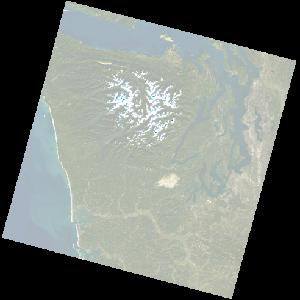

In [14]:
from PIL import Image
from urllib.request import urlopen

Image.open(urlopen(signed_href))